# Dataset structure EDA

```bash
├── test/                             # One test planet, same structure as train
├── train/                            # Generated plots and visualizations
│   └── 1010375142                    # Planets - 1100 numbered directories
│       ├── AIRS-CH0_calibration_0/   # Calibration data
│       │   ├── dark.parquet          # Exposure with closed shutter
│       │   ├── dead.parquet          # Dead or hot pixels
│       │   ├── flat.parquet          # Uniform illuminated surface
│       │   ├── linear_corr.parquet   # Correction for nonlinear response
│       │   └── read.parquet          # Detector read noise
│       │
│       ├── FGS1_calibration_0/       # Same set of calibration files
│       ├── AIRS-CH0_signal_0.parquet # Image data for observation 0
│       └── FGS1_signal_0.parquet     # Image data for observation 0
│
├── adc_info.csv           # Gain & offset for ADC
├── axis_info.parquet      # Instrument axis info
├── sample_submission.csv  # Sample submission for one planet
├── test_star_info.csv     # Star info for sample test system
├── train_star_info.csv    # Star info for training systems
├── train.csv              # True spectra 
└── wavelengths.csv        # Wavelength grid
```

## Notebook set-up

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
import glob
import os
import pickle
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import pandas as pd

# Internal imports
import configuration as config

# Create figures directory for saving plots
figures_dir = f'{config.FIGURES_DIRECTORY}/EDA'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1. Planets & observations

In [2]:
# Count the number of planets in the training dataset
planets = os.listdir(f'{config.RAW_DATA_DIRECTORY}/train')
num_planets = len(list(planets))
print(f'Number of planets in training set: {num_planets}')

Number of planets in training set: 1100


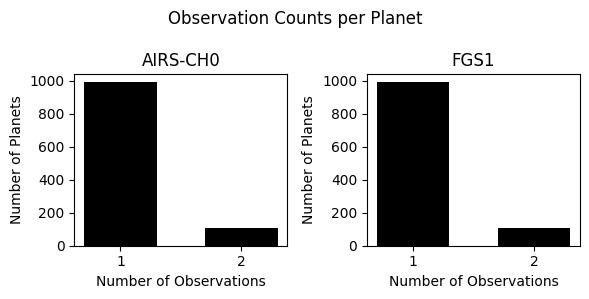

In [3]:
# Count observations per planet for both instruments
airs_observation_counts = []
fgs_observation_counts = []

for planet in planets:
    # Find all AIRS-CH0 observation files for this planet
    airs_observation_files = glob.glob(f'{config.RAW_DATA_DIRECTORY}/train/{planet}/AIRS-CH0_signal_*')
    fgs_observation_files = glob.glob(f'{config.RAW_DATA_DIRECTORY}/train/{planet}/FGS1_signal_*')

    airs_observation_count = len(airs_observation_files)
    fgs_observation_count = len(fgs_observation_files)

    # Check for data quality issues
    if airs_observation_count != fgs_observation_count:
        print(f'Planet {planet} has mismatched observation counts: ' +
              f'AIRS-CH0={airs_observation_count}, FGS1={fgs_observation_count}')

    if airs_observation_count == 0:
        print(f'Planet {planet} has zero AIRS-CH0 observations')

    if fgs_observation_count == 0:
        print(f'Planet {planet} has zero FGS1 observations')

    airs_observation_counts.append(airs_observation_count)
    fgs_observation_counts.append(fgs_observation_count)

# Get unique observation counts and their frequencies for bar plots
from collections import Counter

airs_counts = Counter(airs_observation_counts)
fgs_counts = Counter(fgs_observation_counts)

# Create visualization of observation distribution
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

fig.suptitle('Observation Counts per Planet')

# Create bar plots instead of histograms
airs_obs_nums = sorted(airs_counts.keys())
airs_planet_counts = [airs_counts[obs] for obs in airs_obs_nums]

ax[0].bar(airs_obs_nums, airs_planet_counts, color='black', width=0.6)
ax[0].set_title('AIRS-CH0')
ax[0].set_xlabel('Number of Observations')
ax[0].set_ylabel('Number of Planets')
ax[0].set_xticks(airs_obs_nums)

fgs_obs_nums = sorted(fgs_counts.keys())
fgs_planet_counts = [fgs_counts[obs] for obs in fgs_obs_nums]

ax[1].bar(fgs_obs_nums, fgs_planet_counts, color='black', width=0.6)
ax[1].set_title('FGS1')
ax[1].set_xlabel('Number of Observations')
ax[1].set_ylabel('Number of Planets')
ax[1].set_xticks(fgs_obs_nums)

fig.tight_layout()

# Save the figure
fig.savefig('figures/EDA/01.1-observations_per_planet.jpg', dpi=100, bbox_inches='tight')

The training data contains 1100 planets. Most planets have one observation, but a few have two. There are no missing observations or mismatches between AIRS-CH0 and FGS1 observation counts.

## 2. Stars

In [4]:
# Load and examine star information data
star_df = pd.read_csv(f'{config.RAW_DATA_DIRECTORY}/train_star_info.csv')
star_df.head()

,planet_id,Rs,Ms,Ts,Mp,e,P,sma,i
0,34983,1.155435,1.062961,5577.006645,0.694946,0.0,3.305589,8.550786,89.150759
1,1873185,1.813230,1.370451,6216.229756,0.610845,0.0,6.352660,9.553384,88.701514
2,3849793,0.653807,0.667352,4968.477186,1.529200,0.0,5.522798,15.285661,89.134177
3,8456603,1.250623,1.162019,6023.702622,2.262107,0.0,7.541019,14.144310,87.178007
4,23615382,1.431492,1.306489,6128.061013,0.861299,0.0,4.368080,8.347654,90.000000


In [5]:
# Check data types and completeness of star information
star_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   planet_id  1100 non-null   int64  
 1   Rs         1100 non-null   float64
 2   Ms         1100 non-null   float64
 3   Ts         1100 non-null   float64
 4   Mp         1100 non-null   float64
 5   e          1100 non-null   float64
 6   P          1100 non-null   float64
 7   sma        1100 non-null   float64
 8   i          1100 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 77.5 KB


### Feature info

- **planet_id**: Unique identifier for the star-planet system.
- **Rs**: Stellar radius in solar radii (R☉).
- **Ms**: Stellar mass in solar masses (M☉).
- **Ts**: Stellar effective temperature in Kelvin.
- **Mp**: Planetary mass in Jupiter masses (M⊕).
- **e**: Orbital eccentricity (dimensionless).
- **P**: Orbital period in days.
- **sma**: Semi-major axis in stellar radii (Rs), showing the orbital distance relative to the stellar radii.
- **i**: Orbital inclination in degrees.


In [6]:
# Check for missing star information entries
missing_stars = 0

for planet in planets:

    if int(planet) not in star_df['planet_id'].values:
        missing_stars += 1

print(f'Planets with missing star info: {missing_stars}')

Planets with missing star info: 0


There is information for 1100 stars in the training set, which matches the number of planets. There are no missing star entries.

## 3. Ground truth spectra

In [7]:
# Load and examine ground truth spectra data
spectra_df = pd.read_csv(f'{config.RAW_DATA_DIRECTORY}/train.csv')
spectra_df.head()

,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,wl_274,wl_275,wl_276,wl_277,wl_278,wl_279,wl_280,wl_281,wl_282,wl_283
0,34983,0.018291,0.018088,0.018087,0.018085,0.018084,0.018084,0.018084,0.018084,0.018085,...,0.018109,0.018112,0.018118,0.018123,0.018125,0.018127,0.018130,0.018134,0.018138,0.018142
1,1873185,0.006347,0.006343,0.006343,0.006343,0.006343,0.006343,0.006343,0.006342,0.006342,...,0.006340,0.006340,0.006339,0.006339,0.006339,0.006339,0.006339,0.006339,0.006339,0.006339
2,3849793,0.046061,0.046139,0.046130,0.046117,0.046107,0.046105,0.046109,0.046112,0.046111,...,0.046144,0.046133,0.046131,0.046138,0.046141,0.046147,0.046147,0.046139,0.046134,0.046133
3,8456603,0.015363,0.015387,0.015385,0.015385,0.015385,0.015385,0.015384,0.015383,0.015383,...,0.015471,0.015471,0.015467,0.015465,0.015465,0.015464,0.015461,0.015460,0.015460,0.015460
4,23615382,0.014474,0.014636,0.014628,0.014635,0.014643,0.014642,0.014637,0.014635,0.014639,...,0.014473,0.014467,0.014433,0.014426,0.014435,0.014422,0.014399,0.014429,0.014444,0.014418


In [8]:
# Check data types and structure of spectra data
spectra_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Columns: 284 entries, planet_id to wl_283
dtypes: float64(283), int64(1)
memory usage: 2.4 MB


In [9]:
# Check for missing spectra entries
missing_spectra = 0

for planet in planets:

    if int(planet) not in spectra_df['planet_id'].values:
        missing_stars += 1

print(f'Planets with missing spectra info: {missing_stars}')

Planets with missing spectra info: 0


## 4. Wavelengths

In [10]:
# Load and examine wavelength grid information
wavelength_df = pd.read_csv(f'{config.RAW_DATA_DIRECTORY}/wavelengths.csv')
wavelength_df.head()

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,wl_274,wl_275,wl_276,wl_277,wl_278,wl_279,wl_280,wl_281,wl_282,wl_283
0,0.7,1.951761,1.960612,1.96945,1.978273,1.987083,1.995879,2.004661,2.01343,2.022184,...,3.84972,3.85481,3.859887,3.86495,3.869999,3.875034,3.880055,3.885063,3.890056,3.895036


In [11]:
# Check structure of wavelength data
spectra_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Columns: 284 entries, planet_id to wl_283
dtypes: float64(283), int64(1)
memory usage: 2.4 MB


The wavelengths in the wavelengths.csv file correspond to the wavelengths in the ground truth spectra file. From the competition description, it appears that the wavelength grid spans 0.60 micrometers to 3.90 micrometers. This is the concatenated range for each instrument:

- FGS1: 0.60 - 0.80 um
- AIRS-CH0: 1.95 - 3.90 um

FGS1 is the guidance camera, it takes alignment photos in the visible range. AIRS-CH0 is the actual science instrument, it takes spectra in the IR range. We have only the first channel from both instruments. Here are the wavelength column names covered by each instrument:

In [12]:
# Map wavelength columns to instruments and save for later use
instrument_ranges = {
    'FGS1': ['wl_1'],
    'AIRS-CH0': wavelength_df.columns[1:].tolist()
}

# Save instrument-wavelength mapping to metadata directory
with open(f'{config.METADATA_DIRECTORY}/instrument_wavelengths.pkl', 'wb') as output_file:
    pickle.dump(instrument_ranges, output_file)